In [1]:
import os
import numpy as np
import soundfile as sf
import scipy.signal
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

In [2]:
# === Функции ===
def normalize(x):
    return x / (np.max(np.abs(x)) + 1e-9)

def remove_dc(x):
    return x - np.mean(x)

def align_signals(ref, target):
    corr = scipy.signal.correlate(target, ref, mode='full')
    lag = np.argmax(np.abs(corr)) - len(ref) + 1
    if lag > 0:
        target_aligned = target[lag:]
        ref_aligned = ref[:len(target_aligned)]
    else:
        ref_aligned = ref[-lag:]
        target_aligned = target[:len(ref_aligned)]
    minlen = min(len(ref_aligned), len(target_aligned))
    return ref_aligned[:minlen], target_aligned[:minlen]

def split_into_bands(fft_data, sample_rate, num_bands=16):
    N = len(fft_data)
    freqs = fftfreq(N, 1/sample_rate)
    positive = freqs[:N//2]
    amp = np.abs(fft_data[:N//2])
    band_edges = np.logspace(np.log10(20), np.log10(sample_rate/2), num_bands+1)
    bands = np.zeros(num_bands)
    for i in range(num_bands):
        fmin, fmax = band_edges[i], band_edges[i+1]
        mask = (positive >= fmin) & (positive < fmax)
        if np.any(mask):
            bands[i] = np.mean(amp[mask])
        else:
            bands[i] = 0
    return bands, band_edges

def apply_gains_to_fft(fft_data, sample_rate, gains, band_edges):
    N = len(fft_data)
    freqs = fftfreq(N, 1/sample_rate)
    out_fft = fft_data.copy()
    for i, g in enumerate(gains):
        fmin, fmax = band_edges[i], band_edges[i+1]
        mask_pos = (np.abs(freqs) >= fmin) & (np.abs(freqs) < fmax)
        out_fft[mask_pos] *= g
    return out_fft

def deconv(recorded, original, epsilon=1e-7):
    N = len(recorded)
    orig_zpad = np.zeros(N)
    orig_zpad[:len(original)] = original
    Rec = fft(recorded)
    Orig = fft(orig_zpad)
    H = Rec / (Orig + epsilon)
    ir = ifft(H).real
    return ir

def highpass_ir(ir, sr, lowcut=120.0):
    sos = scipy.signal.butter(1, lowcut, btype='highpass', fs=sr, output='sos')
    return scipy.signal.sosfilt(sos, ir)

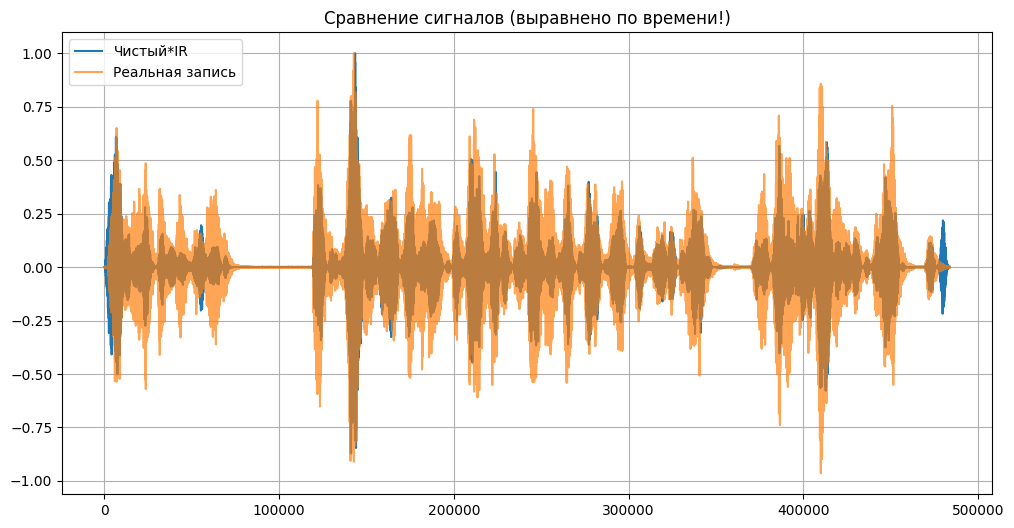

In [3]:
# === 1. Загрузка файлов и нормализация ===
swip_orig, sr_swip = sf.read('sounds/swip_orig.wav', dtype='float32')
swip_rec, sr_swip2 = sf.read('sounds/swip_blanket.wav', dtype='float32')
noise_white, sr_white = sf.read('sounds/noise_white.wav', dtype='float32')
noise_white_recorded, sr_white = sf.read('sounds/corrected_noise_kitchen.wav', dtype='float32')

for sig in [swip_orig, swip_rec, noise_white, noise_white_recorded]:
    if isinstance(sig, np.ndarray) and sig.ndim > 1:
        sig = sig[:,0]

swip_orig, swip_rec = normalize(remove_dc(swip_orig)), normalize(remove_dc(swip_rec))
noise_white = normalize(remove_dc(noise_white))
noise_white_recorded = normalize(remove_dc(noise_white_recorded))

# === 2. ВЫРАВНИВАНИЕ свиперов ===
swip_orig, swip_rec = align_signals(swip_orig[:,0], swip_rec)

# === 3. FFT и разбиение на полосы для свипа ===
num_bands = 16
fft_sweep_orig = fft(swip_orig)
fft_sweep_rec = fft(swip_rec)
amps_orig, band_edges = split_into_bands(fft_sweep_orig, sr_swip, num_bands)
amps_rec, _ = split_into_bands(fft_sweep_rec, sr_swip, num_bands)
eq_gains = np.array([a_rec / (a_orig + 1e-9) for a_rec, a_orig in zip(amps_rec, amps_orig)])

# === 4. ВЫРАВНИВАНИЕ белого шума под свипер ===
noise_white, swip_orig_cutted = align_signals(noise_white[:,0], swip_orig)
# (чтобы их длины точно совпадали для дальнейшего использования)

# === 5. FFT белого шума и коррекция по гейнам (АЧХ) ===
fft_white = fft(noise_white)
inv_eq_gains = 1./(eq_gains + 1e-9)
fft_white_corrected = apply_gains_to_fft(fft_white, sr_white, inv_eq_gains, band_edges)
noise_white_corrected = ifft(fft_white_corrected).real
noise_white_corrected = normalize(noise_white_corrected)

sf.write('sounds/corrected_white_noise.wav', noise_white_corrected.astype('float32'), sr_white)

# === 6. Выравнивание корректированного белого шума и записи (в комнате) ===
noise_white_corrected, noise_white_room = align_signals(noise_white_corrected, noise_white_recorded)

# === 7. Деконволюция: получаем IR ===
ir = deconv(noise_white_room, noise_white_corrected)
peak = np.argmax(np.abs(ir))
win_size = int(0.08 * sr_white)
start = max(peak, 0)
end = min(start+win_size, len(ir))
ir_win = ir[start:end]
ir_win = ir_win * np.hanning(len(ir_win))
ir_win = highpass_ir(ir_win, sr_white, lowcut=100.0)
ir_win = normalize(ir_win)
sf.write('sounds/ir_final.wav', ir_win.astype('float32'), sr_white)

# === 8. Применение IR к чистому сигналу ===
clean_test, sr_test = sf.read('sounds/clear_voice.wav', dtype='float32')
clean_test = normalize(remove_dc(clean_test))

test_convolved = scipy.signal.fftconvolve(clean_test, ir_win, mode='full')
test_convolved = normalize(test_convolved)

# === 9. Сравнение с реальной записью, ВЫРАВНИВАНИЕ басов ===
test_recorded, sr_rec = sf.read('sounds/voice_kitchen.wav', dtype='float32')
test_recorded = normalize(remove_dc(test_recorded))
test_convolved, test_recorded = align_signals(test_convolved, test_recorded)
L = min(len(test_convolved), len(test_recorded))
test_convolved = test_convolved[:L]
test_recorded = test_recorded[:L]

sf.write('sounds/voice_convolved_trimmed.wav', test_convolved.astype('float32'), sr_white)
sf.write('sounds/test_recorded_trimmed.wav', test_recorded.astype('float32'), sr_white)

# === 10. ВИЗУАЛИЗАЦИЯ ===
plt.figure(figsize=(12,6))
plt.plot(test_convolved, label="Чистый*IR")
plt.plot(test_recorded, alpha=0.7, label="Реальная запись")
plt.legend()
plt.title("Сравнение сигналов (выравнено по времени!)")
plt.grid()
plt.show()


Полученный после свертки с импульсным откликом голос на мой слух звучит чуть хуже оригинала - голос стал глуше и зашумленнее. Связываю это с недостаточно качественным выравниванием дорожек во времени.